# Initialize

In [ ]:
data_path = '/content/drive/My Drive/Simulations in Stat learning/data/'
distributions_path = '/content/drive/My Drive/Simulations in Stat learning/distributions/'
images_path = '/content/drive/My Drive/Simulations in Stat learning/videos/1/'

from google.colab import drive
drive.mount('/content/drive')


import matplotlib
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{amsfonts}\usepackage{bm}']
from matplotlib.lines import Line2D
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyre ghostscript gsfonts javascript-common

In [ ]:

import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib inline

from scipy.stats import multivariate_normal
np.random.seed(42) #Change seed to get "GOOD 4 common points"

In [ ]:
#Helper Functions

def get_labels(x,y,distribution):
    if distribution == "circle":
        z = np.where(x**2 + y**2 + 2*0.9*x + 2*0.5*y - 0.2 > 0 , 1 , 0)  
        
    elif distribution == "linear":
        h_labeling = np.array([0.7,0.5])
        
        temp = np.c_[x,y]   #---for animation
        z = np.where(np.matmul(temp,h_labeling) - 0> 0.0, 1, 0)
        
    elif distribution =="wiggly1":
        z = np.where(3*y**3 +x**2 -0.2*y**2 +  0*x - 0.01   >0, 1, 0)
        
    elif distribution =="wiggly2":
        z = np.where(30*x**10 + 2*y**10 -700*x**7 + 20*y**5 -1*x**2 + 0.02   >0, 0, 1)
        
    elif distribution == "l1":
        z1 = np.where(abs(x)+abs(y)>0.15,1,0)
        z2 = np.where(abs(x)+abs(y)>0.4,1,0)

        z = np.logical_xor(z1,z2)
    
    else :
        filename = distributions_path + distribution + ".png"
        im = plt.imread(filename)
        image = np.round(np.sum(im,2)/3)

        x_ = np.floor((x + 0.4)*1000)
        y_ = np.floor((y + 0.4)*1000)

        labels = []
        for i,j in zip(x_.astype(int),y_.astype(int)):

            label = image[i,j]
            labels.append(label)

        z = np.abs(1 - np.array(labels))
    
    
        
    return z

In [ ]:
def get_agnostic_data(m):
    
    half_size = int(m/2)
    
    #random 1
    rv1 = multivariate_normal([-0.1, -0.1], [[0.03, 0], [0, 0.02]])
    rv2 = multivariate_normal([0.1, 0.1], [[0.01, 0], [0, 0.02]])

    #random 2
    #rv1 = multivariate_normal([-0.1, -0.05], [[0.03, 0.005], [0, 0.02]])
    #rv2 = multivariate_normal([0.2, 0.1], [[0.01, 0], [0, 0.02]])


    #predictive
    rv1 = multivariate_normal([-0.2, -0.2], [[0.01, 0.002], [0, 0.01]])
    rv2 = multivariate_normal([0.15, 0.15], [[0.01, 0], [0.004, 0.01]])

    #not predictive
    rv1 = multivariate_normal([-0.01, -0.01], [[0.04, 0], [0, 0.03]])
    rv2 = multivariate_normal([0.01, 0.01], [[0.04, 0], [0, 0.06]])



    samples_1 = rv1.rvs(size=half_size)
    samples_1 = np.c_[samples_1,np.zeros((half_size,1))]
    
    samples_2 = rv2.rvs(size=half_size)
    samples_2 = np.c_[samples_2,np.ones((half_size,1))]
    d = np.r_[samples_2,samples_1]
    np.random.shuffle(d)
        
    return d

In [ ]:
def errors_on_hypothesis_set(data,hypothesis):
    intermediate = np.matmul(data[:,:2], hypothesis.reshape(2,-1))
    predictions = np.where(intermediate > 0.0, 1, 0)
    labels = data[:,2]

    E_out = np.logical_xor(predictions.T,labels)
    true_errors = 1 - np.sum(E_out,axis=1)/E_out.shape[1]
    
    return true_errors,E_out,predictions

# (run only once)Selecting the initial 4 points 

In [ ]:
m = 40000
core_data = np.random.uniform(-0.4,0.4,[m,2])
data = core_data.copy()

In [ ]:

distribution = "circle"
labels_circle = get_labels(data[:,0],data[:,1],distribution)

distribution = "wiggly2"
labels_wiggly2 = get_labels(data[:,0],data[:,1],distribution)


distribution = "skull"
labels_skull = get_labels(data[:,0],data[:,1],distribution)

distribution = "chessboard"
labels_chess = get_labels(data[:,0],data[:,1],distribution)

#Selecting the points which all the distributions label the same
labels = list([labels_circle,labels_wiggly2,labels_skull,labels_chess])
int_labels = []
for l in labels:
    int_labels.append(l.astype('int'))

zz = np.array(int_labels)
z = np.sum(zz,axis=0)

#Selecting 2 white points and 2 black points
ones = np.where(z == zz.shape[0])[0]
zeros = np.where(z == 0)[0]

one_points = data[ones,:].reshape(-1,2)
zero_points = data[zeros,:].reshape(-1,2)

#Hand pick the points
#training_4_points = np.r_[one_points[[458,783],:],zero_points[[496,1369],:]]

wht = np.random.random_integers(0,zero_points.shape[0]-1,2)
blk = np.random.random_integers(0,one_points.shape[0]-1,2)
#

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: This function is deprecated. Please call randint(0, 4137 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: This function is deprecated. Please call randint(0, 1140 + 1) instead


In [ ]:
training_4_points = np.r_[one_points[[blk[0],blk[1]],:],zero_points[[wht[0],wht[1]],:]]

# 1)Knobs, corresponding style and helper functions

In [ ]:

#All the knobs here
#video editing knobs
true_distribution_visible = True
points_visible = False

true_unknown_distribution = "wiggly2"#circle chessboard wiggly2 skull 
is_agnostic = True
specific_hypothesis = 3 # og: 3

#Rarely used
window_only = False
if window_only:
  true_distribution_visible = True
  points_visible = False



#not to be changed
sample_size = 500

# 2) Preparing the background and Training datasets ( Run for change in distribution )

In [ ]:
data = core_data.copy()

In [ ]:
#All the knobs here
sample_size_max = sample_size
distribution = true_unknown_distribution
agnostic = is_agnostic

#h4 = np.array([[0.5,0],
#                [-0.5,0],
#                [0,0.5],
#                [0,-0.5]])

h4 = np.array([[0.5,0],
                [0.3,0.1],
                [0.1,0.3],
                [0,0.5]])

hypothesis = h4[specific_hypothesis,:]

In [ ]:
training_4_points[:,:3].shape

(4, 3)

In [ ]:
training_data.shape

(500, 3)

In [ ]:
 
if agnostic:
  m=40000
  data = get_agnostic_data(m)

  training_data = get_agnostic_data(sample_size_max - 4)
  training_4_points = np.c_[training_4_points,np.r_[np.ones([2,1]),np.zeros([2,1])]]
  training_data = np.r_[training_4_points[:,:3],training_data]
  training_labels = training_data[:,2]

  true_unknown_distribution = "agnostic"
else:
  print(distribution)
  data = np.c_[data,get_labels(data[:,0],data[:,1],distribution).astype(int)]

  training_data = data[:(sample_size_max - 4),:2]
  #training_data = np.random.uniform(-0.4,0.4,[sample_size_max - 4,2])
  training_data = np.r_[training_4_points,training_data]
  
  training_labels = get_labels(training_data[:,0],training_data[:,1],distribution).astype(int)
  training_data = np.c_[training_data,training_labels]

  

true_error,E_out,hypothesis_predictions = errors_on_hypothesis_set(data,hypothesis)
train_error,E_in,training_predictions = errors_on_hypothesis_set(training_data,hypothesis)





In [ ]:
if is_agnostic:
  name = 'agnostic' #agnostic
else:
  name = distribution


np.save(data_path + "data_"+name+'_'+str(40000),data)
np.save(data_path + "training_data_"+name+'_'+str(sample_size_max),training_data)

# 3) Plotting

In [ ]:
#IMPORTANT: THERE HAS TO BE A SAME GET_LABELS_FUNCTION FOR THIS NOTBOOK AND HOEFFDINGS NOTEBOOK

distribution_points_size = 20
distribution_points_alpha = 0.05

sample_points_size = 250
sample_points_alpha = 1

#Standard
plt.rcParams["figure.figsize"] = (24,18)
plt.rcParams['axes.linewidth'] = 7
plt.rcParams['savefig.facecolor']='blue'


if points_visible:
  rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False,
      "axes.facecolor": 'blue'}
  plt.rcParams.update(rc)


if true_distribution_visible:
  rc = {"axes.spines.left" : True,
      "axes.spines.right" : True,
      "axes.spines.bottom" : True,
      "axes.spines.top" : True,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      'text.usetex' : True,
      'savefig.facecolor':'blue',
      "axes.facecolor": 'white',
      "xtick.labelsize" : 12,
      "ytick.labelsize" : 12,
      'xtick.major.pad' : '7',
      'ytick.major.pad' : '7',
      }


  plt.rcParams.update(rc)




  
#CUSTOM COLORMAPS
label_temp = mpl.colors.ListedColormap(['Red', 'Black'])

label_colors = mpl.colors.ListedColormap(['silver', 'Black'])
right_wrong_colors = mpl.colors.ListedColormap(['tomato', 'forestgreen'])

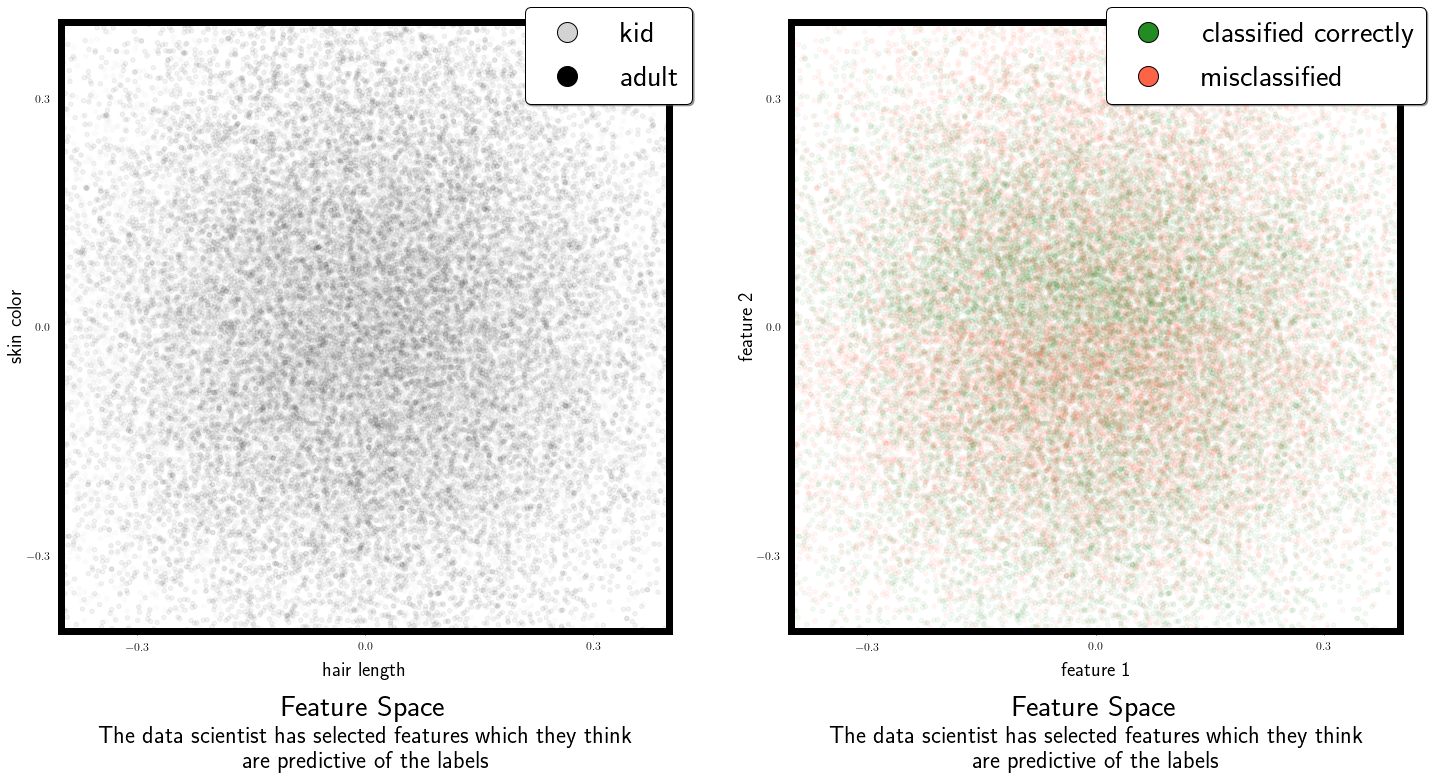

In [ ]:
fig, axs = plt.subplots(1, 2 )
plt.autoscale(False)
#plt.xticks(np.arange(-0.4, 0.4+1, 2.0))
#plt.yticks(np.arange(-0.4, 0.4+1, 2.0))


axs[0].set_xlim([-0.4, 0.4])
axs[0].set_ylim([-0.4, 0.4])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].set_aspect(aspect='equal', adjustable='box')

axs[1].set_xlim([-0.4, 0.4])
axs[1].set_ylim([-0.4, 0.4])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].set_aspect(aspect='equal', adjustable='box')



############################
if true_distribution_visible:
  if window_only == True:
    distribution_points_alpha = 0
  axs[0].scatter(data[:,0],data[:,1],c=label_colors(data[:,2],distribution_points_alpha),s = distribution_points_size)
  axs[1].scatter(data[:,0],data[:,1],c=right_wrong_colors(E_out.reshape(-1),distribution_points_alpha),s = distribution_points_size)

  line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="lightgrey")
  line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="black")
  l1=axs[0].legend((line1,line2),('label a','label b'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.9, 1.05),ncol=1, fancybox=True, shadow=True)
  frame1 = l1.get_frame()
  frame1.set_edgecolor('black')

  line3 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="forestgreen")
  line4 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="tomato")
  l2=axs[1].legend((line3,line4),('classified correctly','misclassified'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.78, 1.05),ncol=1, fancybox=True, shadow=True)
  frame2 = l2.get_frame()
  frame2.set_edgecolor('black')


  axs[0].set_xlabel('feature 1',fontsize = 20,labelpad=10)
  axs[0].set_ylabel('feature 2',fontsize = 20,labelpad=1)
  axs[0].set_title("Feature Space",y = -0.15,fontsize = 30)
  txt="The data scientist has selected features which they think \n are predictive of the labels "
  axs[0].text(0, -0.58, txt, ha='center',fontsize = 24)  

  axs[1].set_xlabel('feature 1',fontsize = 20,labelpad=10)
  axs[1].set_ylabel('feature 2',fontsize = 20,labelpad=1)
  axs[1].set_title("Feature Space",y = -0.15,fontsize = 30)
  txt="The data scientist has selected features which they think \n are predictive of the labels "
  axs[1].text(0, -0.58, txt, ha='center',fontsize = 24)  








if points_visible:
  #Initial setup of facecolors and edgecolors
  edge_colors = np.ones((sample_size_max,4))
  edge_colors[:,3] = 0

  #initial 4 points:
  edge_colors[:4,:3] = 0
  edge_colors[:4,3] = 1

  real_labels = label_colors(training_data[:,2],0.00)
  red_green_labels = right_wrong_colors(E_in.reshape(-1),0.00)

  #initial 4 points
  real_labels[:4,3] = 1
  red_green_labels[:4,3] = 1

  axs[0].scatter(training_data[:,0],training_data[:,1],c=real_labels,s = sample_points_size,edgecolors=edge_colors)
  axs[1].scatter(training_data[:,0],training_data[:,1],c=red_green_labels,s = sample_points_size)



In [ ]:
if points_visible:
  if true_distribution_visible == False:
    file_name = images_path+"points_only_hypo"+str(specific_hypothesis)
else:
  if true_distribution_visible == True:
    file_name = images_path+name+"_distribution_only_hypo"+str(specific_hypothesis)

if window_only:
  file_name = images_path+"window_only"
fig.savefig(file_name +".png")